In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from netam import framework

from netam.framework import (
    SHMoofDataset,
    RSSHMBurrito,
)
from netam import models

import sys
sys.path.append("/Users/matsen/re/netam-experiments-1")
from shmex.shm_zoo import create_model, train_model
from shmex.shm_data import train_val_dfs_of_nickname

Using Metal Performance Shaders


### How do branch lengths compare to normalized mutation frequency?

In [2]:
train_df, val_df = train_val_dfs_of_nickname("cui")
site_count = 500

model = framework.load_crepe("/Users/matsen/re/netam-experiments-1/train/trained_models/fivemer-cui").model
burrito = RSSHMBurrito(
    SHMoofDataset(train_df[:1000], kmer_length=model.kmer_length, site_count=site_count),
    SHMoofDataset(val_df[:1], kmer_length=model.kmer_length, site_count=site_count),
    model,
    )

Loading /Users/matsen/data/cui-et-al-oof_pcp_2024-02-07_MASKED_NI.csv.gz


In [3]:
model.r_kmer_embedding.weight.data -= np.log(10.0)
burrito.optimize_branch_lengths()

Finding optimal branch lengths: 100%|██████████| 1/1 [00:00<00:00, 12.87it/s]


In [4]:
csv_path = "fivemer_modified_branch_lengths.csv"
burrito.train_loader.dataset.export_branch_lengths(csv_path)

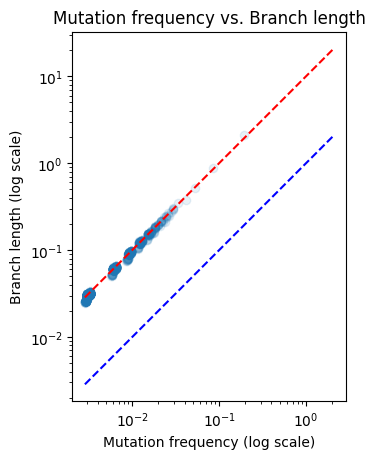

In [5]:
bl_df = pd.read_csv(csv_path)
fig, ax = plt.subplots()
scatter = ax.scatter(
    bl_df["mut_freq"], bl_df["branch_length"], alpha=0.1
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_aspect('equal', 'box')

# Adding the y=x line
min_val = min(bl_df["mut_freq"].min(), bl_df["branch_length"].min())
max_val = max(bl_df["mut_freq"].max(), bl_df["branch_length"].max())
ax.plot([min_val, max_val], [min_val, max_val], 'b--')  # Using red dashed line for y=x
ax.plot([min_val, max_val], [10*min_val, 10*max_val], 'r--')  # Using red dashed line for y=x

ax.set_xlabel("Mutation frequency (log scale)")
ax.set_ylabel("Branch length (log scale)")
ax.set_title("Mutation frequency vs. Branch length")
plt.show()

#### Does this imply that mutation rates are similar across sites?

(0.016945975, 1.0)

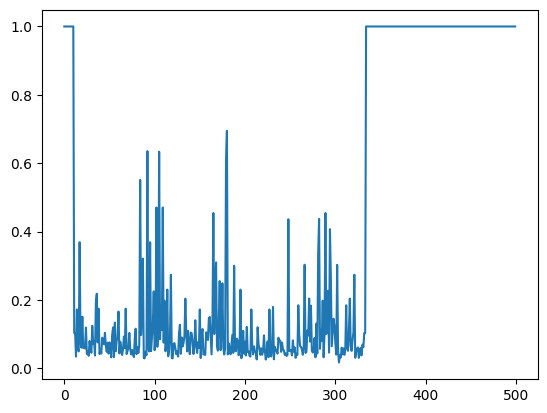

In [6]:
parent = train_df.reset_index(drop=True).loc[0, "parent"]

crepe = burrito.to_crepe()
mutability_profile = crepe([parent])[0].squeeze().detach().numpy()
pd.Series(mutability_profile).plot()
least_mutable_idx, most_mutable_idx = mutability_profile.argmin(), mutability_profile.argmax()
mutability_profile.min(), mutability_profile.max()


In [7]:
parent[least_mutable_idx], parent[most_mutable_idx]
long_child = parent[:least_mutable_idx] + "A" + parent[least_mutable_idx+1:]
short_child = parent[:most_mutable_idx] + "A" + parent[most_mutable_idx+1:]

In [8]:
# make mini_df as two copies of train_df[:1].reset_index(drop=True).copy()
mini_df = pd.concat([train_df[:1]]*2).reset_index(drop=True)
mini_df.loc[0, "child"] = long_child
mini_df.loc[1, "child"] = short_child

# drop the branch_length column
mini_df = mini_df.drop(columns="branch_length")

mini_df

,sample_id,family,parent,child,v_gene,child_is_leaf
0,NP+GC1_BC9_IGL_Export_2017-02-02,35,NNNNNNNNNNNCAGGCTGTTGTGACTCAGGAATCTGCACTCACCAC...,NNNNNNNNNNNCAGGCTGTTGTGACTCAGGAATCTGCACTCACCAC...,IGLV1*01,False
1,NP+GC1_BC9_IGL_Export_2017-02-02,35,NNNNNNNNNNNCAGGCTGTTGTGACTCAGGAATCTGCACTCACCAC...,ANNNNNNNNNNCAGGCTGTTGTGACTCAGGAATCTGCACTCACCAC...,IGLV1*01,False


In [9]:
model = framework.load_crepe("/Users/matsen/re/netam-experiments-1/train/trained_models/fivemer-cui").model
burrito = RSSHMBurrito(
    None,
    SHMoofDataset(mini_df, kmer_length=model.kmer_length, site_count=site_count),
    model,
    )

burrito.optimize_branch_lengths(learning_rate=1e-2)
burrito.val_loader.dataset.branch_lengths.numpy()

Finding optimal branch lengths: 100%|██████████| 2/2 [00:00<00:00, 151.96it/s]


array([0.00302784, 0.        ], dtype=float32)

In [10]:
0.026549237644631712 - 0.02654923765845697

-1.3825256911514927e-11

,log_branch_length,mut_at_low,mut_at_high
0,-4.000000,-1.218917,-3.197539
1,-3.444444,-0.958472,-2.954119
2,-2.888889,-0.710444,-2.736222
3,-2.333333,-0.483123,-2.562811
4,-1.777778,-0.289097,-2.466934
5,-1.222222,-0.144934,-2.506187
6,-0.666667,-0.065603,-2.780949
7,-0.111111,-0.050474,-3.466151
8,0.444444,-0.078186,-4.866613
9,1.000000,-0.135915,-7.513416


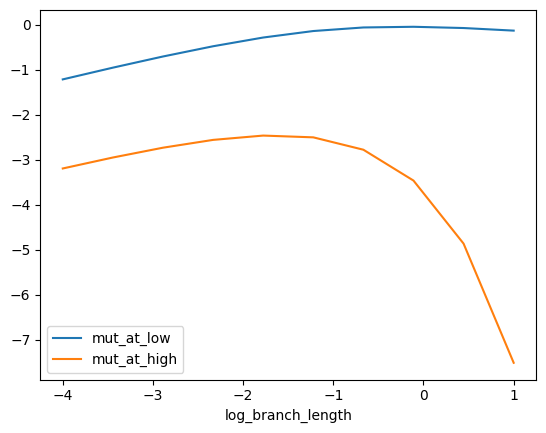

In [11]:
import torch

def log_pcp_probability_of_data(rates, mask, mutation_indicator):
    mutation_indicator_masked = mutation_indicator[mask]
    bce_loss = torch.nn.BCELoss()

    def log_pcp_probability(log_branch_length):
        # Assuming log_branch_length is already a float64 tensor
        # Convert the branch length from log space
        branch_length = torch.exp(log_branch_length.float()).double()  # Convert to float32 for model, then back to float64
        
        # Compute mutation probability
        mut_prob = 1 - torch.exp(-rates * branch_length)
        
        # Apply mask and convert mutation indicators to float
        mut_prob_masked = mut_prob[mask]
        
        # Calculate the rate loss directly
        rate_loss = bce_loss(mut_prob_masked, mutation_indicator_masked)
        
        # Return the negative rate loss (assuming minimization)
        return -rate_loss.item()
    
    return log_pcp_probability

rates = torch.tensor([0.1, 5.0], dtype=torch.float64)
mask = torch.ones(2, dtype=torch.bool)
mutation_indicators = {"mut_at_low": [0, 1], "mut_at_high": [1, 0]}
closures = {k: log_pcp_probability_of_data(rates, mask, torch.tensor(v, dtype=torch.float64)) for k, v in mutation_indicators.items()}

log_branch_lengths = torch.tensor(np.linspace(-4, 1, 10))
plot_df = pd.DataFrame({"log_branch_length": log_branch_lengths})

for k, closure in closures.items():
    closure(log_branch_lengths[0])
    plot_df[k] = [closure(log_branch_length) for log_branch_length in log_branch_lengths]

plot_df.set_index("log_branch_length").plot()
plot_df

/var/folders/16/pkph6n2962g3lf2wpwwt0wwr0000gn/T/ipykernel_64335/3704591027.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  closures = {k: log_pcp_probability_of_data(rates, mask, torch.tensor(v, dtype=torch.float64)) for k, v in mutation_indicators.items()}


<Axes: xlabel='log_branch_length'>

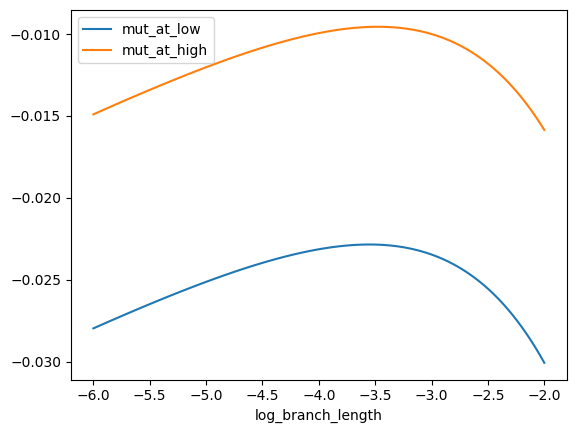

In [12]:
# make rates = constant tensor of 0.1 with length 300
site_count = 300
rates = torch.tensor([0.1]*site_count, dtype=torch.float64)
rates[0] = 5.0
mask = torch.ones(site_count, dtype=torch.bool)
mutation_indicators = {"mut_at_low": torch.zeros(site_count), "mut_at_high": torch.zeros(site_count)}
mutation_indicators["mut_at_low"][1] = 1
mutation_indicators["mut_at_high"][0] = 1
closures = {k: log_pcp_probability_of_data(rates, mask, torch.tensor(v, dtype=torch.float64)) for k, v in mutation_indicators.items()}

log_branch_lengths = torch.tensor(np.linspace(-6, -2, 100))
plot_df = pd.DataFrame({"log_branch_length": log_branch_lengths})

for k, closure in closures.items():
    closure(log_branch_lengths[0])
    plot_df[k] = [closure(log_branch_length) for log_branch_length in log_branch_lengths]

plot_df.set_index("log_branch_length").plot()

<Axes: xlabel='mut_freq', ylabel='branch_length'>

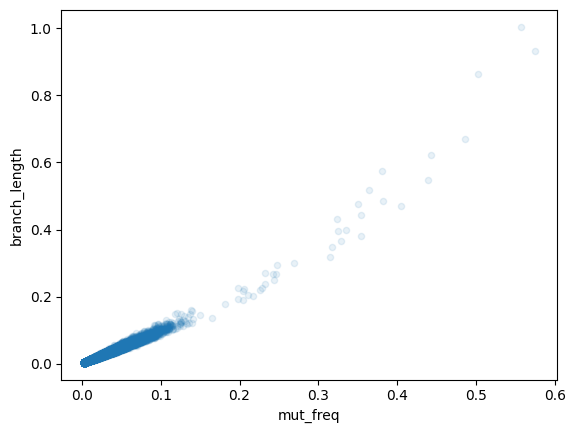

In [13]:
pd.read_csv("cnn_hyb_lrg-shmoof_small.train_branch_lengths.csv").plot.scatter(x="mut_freq", y="branch_length", alpha=0.1)

<Axes: ylabel='Frequency'>

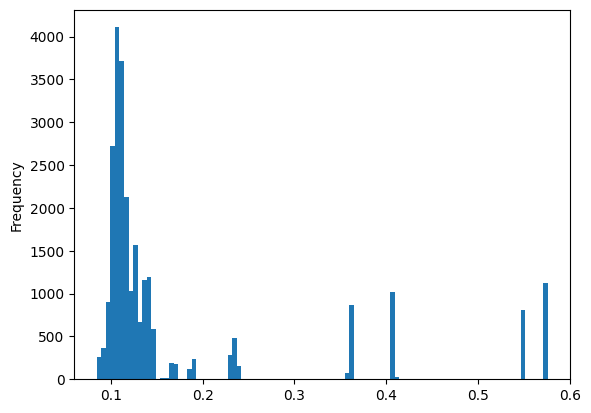

In [35]:
rates, csps = crepe(train_df["parent"].values)
mean_rates = torch.mean(rates[:, 40:330], axis=1).detach().numpy()
pd.Series(mean_rates).plot.hist(bins=100)

In [49]:
# get indices where (mean_rates > 0.57)
indices = np.where(mean_rates > 0.57)[0]
mean_rates[indices[0]]

0.57417893

(0.032659877, 1.0)

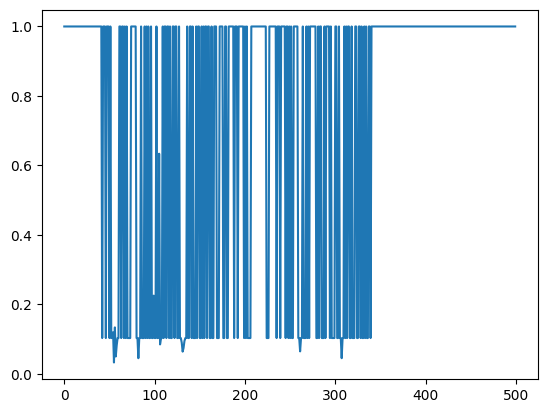

In [51]:
parent = train_df.reset_index(drop=True).loc[indices[0], "parent"]

mutability_profile = crepe([parent])[0].squeeze().detach().numpy()
pd.Series(mutability_profile).plot()
least_mutable_idx, most_mutable_idx = mutability_profile.argmin(), mutability_profile.argmax()
mutability_profile.min(), mutability_profile.max()

In [52]:
parent

'NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCNNNANNNCNTGGTGAAACNNTNNCNCNCACTNNNNNNTCAAGNACTNGNGNTGNTACAANTAGTAANTNNGNNANCTNNGNNCANGAAAAACCNGANNANTTANTNNCTNGNCNNANNGGNGGNNNCAANNNNCGNNCTNNNNNNGNNNCNNNNNNANTNTCAGNNNNNNNNNNNNNNNNNAAGNNNNNNNNCNNNANNNNNGNNGNANAGNNNNNGGATGNGGCNANANNNNNNNGTNCNNTATNGNNNNGNAACCNNTTNGGTGTNCNGNNGANGAANNAANNTNACNGNCCNNG'

In [55]:
dict(train_df.reset_index(drop=True).loc[indices[0]])

{'sample_id': 'NP+GC3_BC11_IGL_Export_2017-02-02-10k',
 'family': 0,
 'parent': 'NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCNNNANNNCNTGGTGAAACNNTNNCNCNCACTNNNNNNTCAAGNACTNGNGNTGNTACAANTAGTAANTNNGNNANCTNNGNNCANGAAAAACCNGANNANTTANTNNCTNGNCNNANNGGNGGNNNCAANNNNCGNNCTNNNNNNGNNNCNNNNNNANTNTCAGNNNNNNNNNNNNNNNNNAAGNNNNNNNNCNNNANNNNNGNNGNANAGNNNNNGGATGNGGCNANANNNNNNNGTNCNNTATNGNNNNGNAACCNNTTNGGTGTNCNGNNGANGAANNAANNTNACNGNCCNNG',
 'child': 'NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCNNNANNNCNTGGTGAAACNNTNNCNCNCACTNNNNNNTCAAGNACTNGNGNTGNTACAANTAGTAANTNNGNNANCTNNGNNCANGAAAAACCNGANNANTTANTNNCTNGNCNNANNGGNGGNNNCAANNNNCGNNCTNNNNNNGNNNCNNNNNNANTNTCAGNNNNNNNNNNNNNNNNNAAGNNNNNNNNCNNNANNNNNGNNGNANAGNNNNNGGATGNGGCNANANNNNNNNGTNCNNTATNGNNNNGNAACCNNCTNGGTGTNCNGNNGANGAANNAANNTNACNGNCCNNG',
 'branch_length': 0.0030493078,
 'v_gene': 'IGLV1*01',
 'child_is_leaf': False}